Found 82 filing tags with 1345723 total file locations


,tag,description,file_locations_count
6,G,Construction,293214
51,F5,Drawings and Specifications,271847
5,F,Bid Documents and Contract Award,265364
7,H,Submittals,86014
70,G21,Construction Photos and Videos,68035
60,G12,Request for Information (RFI),47635
2,C,Consultants,44465
4,E,Program and Design,38142
0,A,General,21408
76,G5,Inspectors' Daily Reports and Inspection Requests,20674


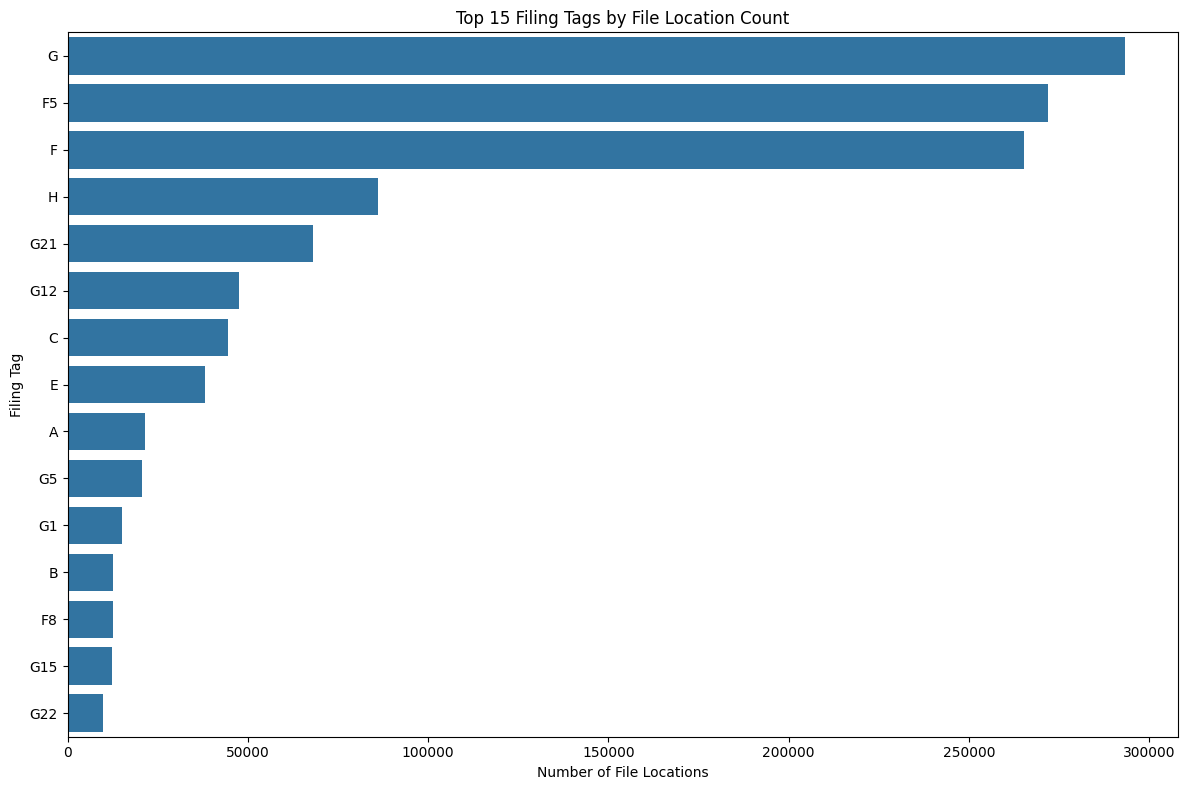

In [3]:
import os
from db_models import FilingTag, FileLocation, File
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_db_engine():
    """Create and return a SQLAlchemy engine for the project database."""
    conn_string = (
        f"postgresql+psycopg://{os.getenv('PROJECT_DB_USERNAME')}:{os.getenv('PROJECT_DB_PASSWORD')}"
        f"@{os.getenv('PROJECT_DB_HOST')}:{os.getenv('PROJECT_DB_PORT')}/{os.getenv('PROJECT_DB_NAME')}"
    )
    return create_engine(conn_string)

# Configure your database session
engine = get_db_engine()
Session = sessionmaker(bind=engine)
session = Session()

def file_tag_file_locations(filing_tag):
    """
    Find all FileLocation entries where file_server_directories contains the filing tag label.
    
    Args:
        filing_tag (FilingTag): The filing tag object to search for
    
    Returns:
        list: FileLocation entries matching the criteria
    """
    search_pattern = f"{filing_tag.label} - "
    
    # Query for FileLocation entries where file_server_directories contains the pattern
    locations = session.query(FileLocation).filter(
        FileLocation.file_server_directories.like(f"%{search_pattern}%")
    ).all()
    
    return locations

# Get all filing tags
all_filing_tags = session.query(FilingTag).all()

# Create a list to store results
results = []

# Iterate through all filing tags
for tag in all_filing_tags:
    # Get matching file locations
    locations = file_tag_file_locations(tag)
    count = len(locations)
    
    # Add to results
    results.append({
        'tag': tag.label,
        'description': tag.description,
        'file_locations_count': count
    })

# Convert to DataFrame for better visualization
df_results = pd.DataFrame(results)

# Sort by count in descending order
df_results = df_results.sort_values('file_locations_count', ascending=False)

# Display summary statistics
print(f"Found {len(df_results)} filing tags with {df_results['file_locations_count'].sum()} total file locations")

# Display top tags by location count
display(df_results.head(20))

# Visualize the top 15 tags by file location count
plt.figure(figsize=(12, 8))
top_tags = df_results.head(15)
sns.barplot(x='file_locations_count', y='tag', data=top_tags)
plt.title('Top 15 Filing Tags by File Location Count')
plt.xlabel('Number of File Locations')
plt.ylabel('Filing Tag')
plt.tight_layout()
plt.show()

In [4]:
# create spreadsheet from df_results
df_results.to_csv('filing_tags_file_locations_summary.csv', index=False)

In [1]:
import os
import psycopg
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve database credentials from environment variables
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")

# Establish a connection to the database
conn = psycopg.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST
)

# Create a cursor to execute SQL commands
cur = conn.cursor()

# SQL statements to create tables
sql_commands = [
    """
    CREATE TABLE prototype_runs (
      run_id SERIAL PRIMARY KEY,
      model_name TEXT NOT NULL,
      model_version TEXT NOT NULL,
      algorithm TEXT NOT NULL,
      hyperparams JSONB,
      tag_filter TEXT,
      created_at TIMESTAMPTZ DEFAULT now()
    );
    """,
    """
    CREATE TABLE prototype_members (
      run_id INTEGER REFERENCES prototype_runs(run_id) ON DELETE CASCADE,
      tag TEXT REFERENCES filing_tags(label),
      prototype_id SMALLINT DEFAULT 0,
      file_id INTEGER REFERENCES files(id),
      PRIMARY KEY (run_id, tag, prototype_id, file_id)
    );
    """,
    """
    ALTER TABLE tag_prototypes ADD COLUMN run_id INTEGER
      REFERENCES prototype_runs(run_id) ON DELETE SET NULL;
    """,
    """
    CREATE TABLE prototype_run_metrics (
      run_id INTEGER REFERENCES prototype_runs(run_id) ON DELETE CASCADE,
      metric_name TEXT,
      value NUMERIC,
      split TEXT,
      PRIMARY KEY (run_id, metric_name, split)
    );
    """
]

# Execute each command
for command in sql_commands:
    cur.execute(command)

# Commit changes and close the connection
conn.commit()
cur.close()
conn.close()

OperationalError: connection failed: connection to server at "localhost" (::1), port 5432 failed: fe_sendauth: no password supplied

In [ ]:
import os
from pathlib import Path
from itertools import islice


def visualize_directory_tree(
    dir_path: Path,
    level: int = -1,
    limit_to_directories: bool = False,
    length_limit: int = 1000000,
    exclusion_list: list = None
):
    """Given a directory Path object print a visual tree structure, with optional exclusions."""
    space = '    '
    branch = '│   '
    # pointers:
    tee = '├── '
    last = '└── '

    dir_path = Path(dir_path)  # accept string coerceable to Path
    files = 0
    directories = 0
    exclusion_set = set(exclusion_list) if exclusion_list else set()

    def inner(dir_path: Path, prefix: str = '', level=-1):
        nonlocal files, directories
        if not level:
            return  # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir() and d.name not in exclusion_set]
        else:
            contents = [d for d in dir_path.iterdir() if d.name not in exclusion_set]
        pointers = [tee] * (len(contents) - 1) + [last] if contents else []
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space
                yield from inner(path, prefix=prefix + extension, level=level - 1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1

    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))
# exclude irrelevant directories
exclude_dirs = [
    '.venv',
    '__pycache__',
    'dev\__pycache__',
    '.git'
]

visualize_directory_tree(
    dir_path= os.getcwd(),
    exclusion_list= exclude_dirs
)

file_code_tagger
├── .env
├── .gitignore
├── add_file_tags.py
├── create_db_tables.sql
├── db_models.py
├── dev
│   ├── archives_backup.dump
│   ├── archives_backup_20250722_210636.sql
│   ├── archives_db.py
│   ├── dev_utils.py
│   ├── docker-compose.yml
│   ├── filing_tags_file_locations_summary.csv
│   ├── new_filing_codes.txt
│   ├── proposed project structure.txt
│   └── sync_tables_v1.py
├── dev_notebook.ipynb
├── embedding
│   ├── base.py
│   └── minilm.py
├── sync_tables.py
├── test_db_access.py
├── utils.py
└── __init__.py

2 directories, 21 files


<>:55: SyntaxWarning: invalid escape sequence '\_'
<>:55: SyntaxWarning: invalid escape sequence '\_'
C:\Users\adankert\AppData\Local\Temp\ipykernel_26096\3449408558.py:55: SyntaxWarning: invalid escape sequence '\_'
  'dev\__pycache__',


: 

In [ ]:
import os
from text_extraction.pdf_extraction import PDFTextExtractor

def test_pdf_text_extraction(directory_path):
    """
    Test PDF text extraction on all files in the given directory.
    
    Args:
        directory_path (str): Path to the directory containing PDF files.
    """
    extractor = PDFTextExtractor()
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.pdf'):
                file_path = os.path.join(root, file)
                try:
                    print(f"Extracting text from: {file_path}")
                    text = extractor(file_path)
                    print(f"Extracted text (first 500 characters):\n{text[:500]}\n")
                except Exception as e:
                    print(f"Failed to extract text from {file_path}: {e}")

# Example usage
test_directory = "path/to/your/pdf/directory"
test_pdf_text_extraction(test_directory)